## BM25 + Cross-Encoder for Retrieval & Re-ranking
#### In this notebook, we'll:
#### - Use BM25 to quickly retrieve candidate documents.
#### - Apply a Cross-Encoder to re-rank those candidates.
#### - Compare the scores using a DataFrame and visualize the results.
#
#### This notebook is designed for experiment purposes and can run on modest hardware.
#


### Dataset Preparation
#### We'll create a small, in-notebook corpus of documents for demonstration.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder

In [2]:
documents = [
    "Machine learning is a subfield of artificial intelligence.",
    "Artificial intelligence includes machine learning, deep learning, and neural networks.",
    "Natural language processing enables computers to understand human language.",
    "Reinforcement learning is a machine learning technique inspired by behavioral psychology.",
    "Quantum computing is an area of computing focused on quantum mechanics.",
    "Climate change affects ecosystems around the world.",
    "Space exploration helps humanity discover new planets and galaxies.",
    "Nutrition and exercise are important for human health.",
    "Vaccinations are critical for public health and disease prevention.",
    "Economic policies affect global trade and market stability."
]

In [3]:
df = pd.DataFrame(documents, columns=['text'])
print("Dataset:")
print(df)

Dataset:
                                                text
0  Machine learning is a subfield of artificial i...
1  Artificial intelligence includes machine learn...
2  Natural language processing enables computers ...
3  Reinforcement learning is a machine learning t...
4  Quantum computing is an area of computing focu...
5  Climate change affects ecosystems around the w...
6  Space exploration helps humanity discover new ...
7  Nutrition and exercise are important for human...
8  Vaccinations are critical for public health an...
9  Economic policies affect global trade and mark...


In [4]:
def bm25_retrieve(query, corpus, top_n=5):
    """
    Retrieve the top_n documents from the corpus based on BM25 scores.
    
    Parameters:
        query (str): The search query.
        corpus (list): List of documents (strings).
        top_n (int): Number of top documents to return.
        
    Returns:
        List of tuples (BM25 score, document) sorted in descending order.
    """
    tokenized_corpus = [doc.lower().split() for doc in corpus]     # Simple tokenization: lowercase and split on whitespace
    bm25 = BM25Okapi(tokenized_corpus)
    query_tokens = query.lower().split()
    scores = bm25.get_scores(query_tokens)
    ranked_results = sorted(zip(scores, corpus), key=lambda x: x[0], reverse=True)[:top_n]     # Pair scores with documents and sort by score descending
    return ranked_results

In [5]:
query = "What is machine learning?" # Define a query
top_n = 5
bm25_results = bm25_retrieve(query, documents, top_n=top_n) # Retrieve top documents using BM25
print("Top documents retrieved by BM25:")
for idx, (score, doc) in enumerate(bm25_results, 1):
    print(f"{idx}. BM25 Score: {score:.4f} | Document: {doc}")

Top documents retrieved by BM25:
1. BM25 Score: 1.6045 | Document: Machine learning is a subfield of artificial intelligence.
2. BM25 Score: 1.3857 | Document: Reinforcement learning is a machine learning technique inspired by behavioral psychology.
3. BM25 Score: 0.7258 | Document: Artificial intelligence includes machine learning, deep learning, and neural networks.
4. BM25 Score: 0.6929 | Document: Quantum computing is an area of computing focused on quantum mechanics.
5. BM25 Score: 0.0000 | Document: Natural language processing enables computers to understand human language.


### Step 2: Re-ranking with Cross-Encoder
#
##### Cross-Encoders jointly encode the query and a candidate document, providing a fine-grained relevance score.
##### We'll define a function for re-ranking the candidate documents using a pre-trained Cross-Encoder.


In [6]:
def cross_encoder_rerank(query, candidate_docs, model_name='cross-encoder/ms-marco-MiniLM-L6-v2'):
    """
    Re-rank candidate documents using a Cross-Encoder.
    
    Parameters:
        query (str): The search query.
        candidate_docs (list): List of candidate documents.
        model_name (str): Hugging Face model name for the Cross-Encoder.
        
    Returns:
        Tuple: (List of tuples (Cross-Encoder score, document) sorted descending, list of raw scores)
    """
    cross_encoder = CrossEncoder(model_name)
    pairs = [(query, doc) for doc in candidate_docs] # Prepare (query, document) pairs
    scores = cross_encoder.predict(pairs)
    ranked_results = sorted(zip(scores, candidate_docs), key=lambda x: x[0], reverse=True)
    return ranked_results, scores


In [7]:
candidate_docs = [doc for _, doc in bm25_results] # Extract candidate documents from BM25 results
cross_ranked_results, cross_scores = cross_encoder_rerank(query, candidate_docs) # Re-rank using Cross-Encoder

print("Documents re-ranked by Cross-Encoder:")
for idx, (score, doc) in enumerate(cross_ranked_results, 1):
    print(f"{idx}. Cross-Encoder Score: {score:.4f} | Document: {doc}")

Documents re-ranked by Cross-Encoder:
1. Cross-Encoder Score: 10.8866 | Document: Machine learning is a subfield of artificial intelligence.
2. Cross-Encoder Score: 4.9833 | Document: Reinforcement learning is a machine learning technique inspired by behavioral psychology.
3. Cross-Encoder Score: 2.0963 | Document: Artificial intelligence includes machine learning, deep learning, and neural networks.
4. Cross-Encoder Score: -7.0372 | Document: Natural language processing enables computers to understand human language.
5. Cross-Encoder Score: -8.4634 | Document: Quantum computing is an area of computing focused on quantum mechanics.


### Step 3: Compare and Visualize Results
#
##### Let's put the BM25 and Cross-Encoder scores into a DataFrame for a side-by-side comparison,
##### and then visualize the scores using a bar chart.

In [8]:
bm25_scores_only = [score for score, _ in bm25_results]

comparison_df = pd.DataFrame({
    'Document': candidate_docs,
    'BM25 Score': bm25_scores_only,
    'Cross-Encoder Score': cross_scores
})

comparison_df = (
    comparison_df
    .sort_values(by='Cross-Encoder Score', ascending=False)
    .reset_index(drop=True)
)

pd.set_option('display.max_colwidth', 100)

print("Comparison of BM25 and Cross-Encoder Scores:\n")
display(comparison_df) 

Comparison of BM25 and Cross-Encoder Scores:



,Document,BM25 Score,Cross-Encoder Score
0,Machine learning is a subfield of artificial intelligence.,1.604505,10.886590
1,Reinforcement learning is a machine learning technique inspired by behavioral psychology.,1.385709,4.983290
2,"Artificial intelligence includes machine learning, deep learning, and neural networks.",0.725848,2.096253
3,Natural language processing enables computers to understand human language.,0.000000,-7.037168
4,Quantum computing is an area of computing focused on quantum mechanics.,0.692855,-8.463387


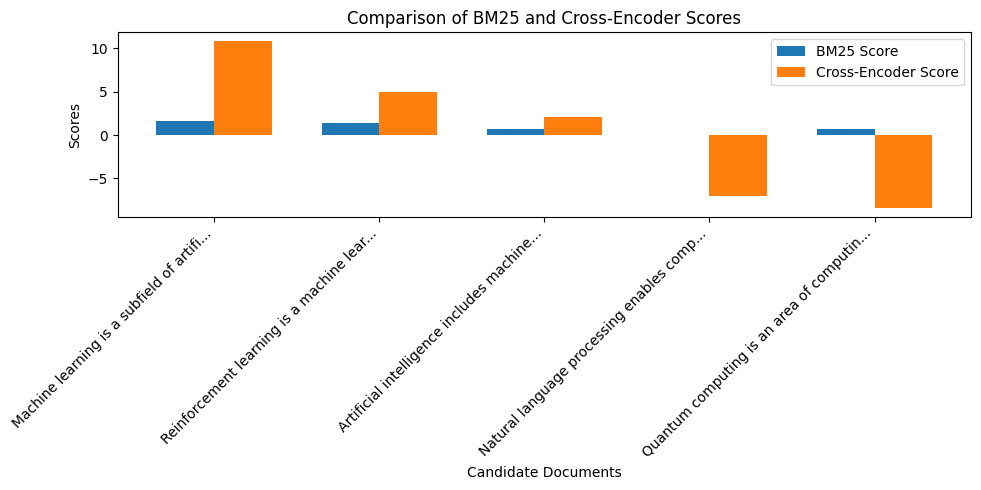

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
indices = range(len(comparison_df))

bars1 = ax.bar(indices, comparison_df['BM25 Score'], bar_width, label='BM25 Score')
bars2 = ax.bar([i + bar_width for i in indices], comparison_df['Cross-Encoder Score'], bar_width, label='Cross-Encoder Score')

ax.set_xlabel('Candidate Documents')
ax.set_ylabel('Scores')
ax.set_title('Comparison of BM25 and Cross-Encoder Scores')
ax.set_xticks([i + bar_width/2 for i in indices])
ax.set_xticklabels([doc[:40] + "..." if len(doc) > 40 else doc for doc in comparison_df['Document']], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()